In [122]:
import json
import re
import pandas as pd
import numpy as np
from unidecode import unidecode
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import f1_score,precision_score, recall_score

In [123]:
def extract_info(json_file):

    data_list = []
    # Charger le fichier JSON
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Parcourir chaque élément du JSON
    for img, info in data.items():
        # Diviser les informations en lignes en séparant par "\n"
        lines = info.split("\n")

        # Parcourir chaque ligne
        for line in lines:
            # Retirer les éléments vides résultant de la division
            elements = re.findall(r"[\S\s]*?(?=Ⓟ|Ⓞ|Ⓕ|Ⓜ|Ⓐ|Ⓒ|Ⓚ|Ⓑ|Ⓘ|Ⓗ|Ⓔ|$)", line)
            elements = [element.strip() for element in elements if element.strip()]
            target, nom, prenom, profession, lien, age, annee, nationalite, ville, biz = "", "", "", "", "", "", "", "", "", ""
            for element in elements:
                # Supprimer les logos de la colonne "nom"
                #element = element.replace('Ⓞ', '').replace('Ⓟ', '')  # Supprimer les logos Ⓞ et Ⓟ
                if 'Ⓟ' in element:
                    target=True
                    nom=element.replace('Ⓟ', '')
                elif 'Ⓞ' in element:
                    target=False
                    nom=element.replace('Ⓞ', '')
                elif 'Ⓕ' in element:
                    prenom=element.replace('Ⓕ', '')
                elif 'Ⓜ' in element:
                    profession=element.replace('Ⓜ', '')
                elif 'Ⓐ' in element:
                    age=element.replace('Ⓐ', '')
                elif 'Ⓚ' in element:
                    nationalite=element.replace('Ⓚ', '')
                elif 'Ⓑ' in element:
                    annee=element.replace('Ⓑ', '')
                elif 'Ⓘ' in element:
                    ville=element.replace('Ⓘ', '')
                elif 'Ⓗ' in element or 'Ⓒ' in element:
                    if 'Ⓛ' in element:
                        element=element.replace('Ⓗ', '').replace('Ⓒ', '')
                        lien=element.split('Ⓛ', 1)[0]
                    else:
                        lien=element.replace('Ⓗ', '').replace('Ⓒ', '') 
                elif 'Ⓔ' in element:
                    biz=element.replace('Ⓔ', '')

                    
            # Stocker les données dans un dictionnaire
            data_dict = {'Target': target, 'Nom': nom, 'Prenom': prenom, 'Profession': profession,
                            'Relation': lien, 'Age': age,'Année':annee, 'Nationalité': nationalite, 'Ville': ville, 'Plus':biz}
            # Ajouter le dictionnaire à la liste
            data_list.append(data_dict)

    return pd.DataFrame(data_list)

In [124]:
# Chemin vers le fichier JSON
json_file = "entities.json"

# Appeler la fonction pour extraire les informations et créer le dataset
df=extract_info(json_file)

df.head()

,Target,Nom,Prenom,Profession,Relation,Age,Année,Nationalité,Ville,Plus
0,False,Breton,Cyrille,menuisier,Garçon,25,,française,,
1,True,Ferazzi,Auguste,vitrier,Garçon,30,,Piémontaise,,
2,True,Machol,Pierre,vitrier,Garçon,24,,Piémontaise,,
3,True,Desbois,Alexandre,prop re,Homme marié,48,,française,,
4,False,Vignat,Zélie,prop re,sa fe,30,,française,,


In [125]:
# enlever les lignes vides
df=df[(df['Relation']!='')&((df['Age']!='')|(df['Année']!=''))]

In [126]:
#enlever les lignes où il y a chef et l'etiquette est false
index_to_drop = df[(df['Target'] == False) & ((df['Relation'].str.startswith('ch')) | (df['Relation'].str.startswith('Ch')))].index
df = df.drop(index_to_drop)

In [127]:
df.shape

(22778, 10)

## Data Preprocessing
###  AGE 

In [128]:
def extract_age(text):

    if text=='':
        return -1

    elif text.isdigit():
        if 120 < int(text) < 2000:
            return int(text[:2])
        else:
            return int(text)

    elif ('mois' in text.lower()) or ('mpois' in text.lower()):
        # Extraire le nombre avant "mois"
        if (text.split()[0].isdigit()) and ((int(text.split()[0])/12) >=1):
            age_in_months = int(text.split()[0])
            age_in_years = age_in_months / 12
            return int(age_in_years)
        else:
            return 1

    elif any(keyword in text.lower() for keyword in ['jours', 'jour', 'semaines','semaine']):
        return 1

    else:
        # Utiliser une expression régulière pour trouver le premier nombre dans la chaîne
        match = re.search(r'\d+', text)
        if match:
            # Renvoyer le nombre trouvé
            return int(match.group())
        else:
            return -1

In [129]:
df['Age'] = df['Age'].apply(extract_age)

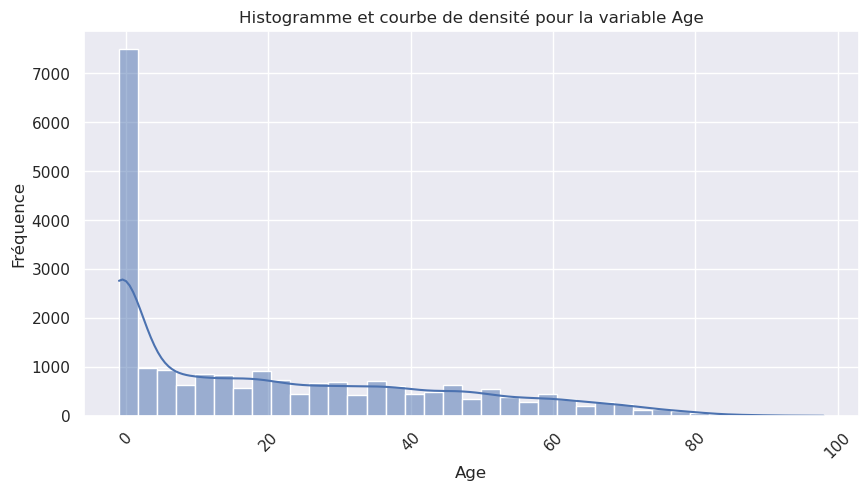

In [130]:
plt.figure(figsize=(10, 5))
df_sorted = df.sort_values('Age')
sns.histplot(df_sorted['Age'], kde=True)
plt.xlabel('Age')
plt.ylabel('Fréquence')
plt.title("Histogramme et courbe de densité pour la variable Age")
plt.xticks(rotation=45)  # Modifier cet angle selon tes préférences
plt.show()

### Relation

In [131]:
# nettoyer les valeurs
def clean_relation(text):

    if 'Ⓒ' in text:
        text = text.replace('Ⓒ', '')

    prefixes = ('chef', 'chf', 'ch.', 'ch de','ch')

    if text.startswith(prefixes):
        return 'chef'

    text=text.lower()
    pronom_list=['le','la','les','leur','leurs','son','sa','ses','de celui','celui ci','de celle ci','à']

    pattern = r'(du |de ch|au ch|de la|chez|des|de l).*'
    text = re.sub(pattern, '', text).strip()
    
    pronom_pattern = r'\b(?:' + '|'.join(pronom_list) + r')\b'
    text=re.sub(pronom_pattern, '',text).strip()

    text=unidecode(text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    if text=='f' or text=='fe':
        return 'femme'

    if text=='id':
        return 'idem'
   
    else:
        return text

In [132]:
# Regrouper les valeurs
def group_relation(text):
    relation_groups = ['fille', 'fils', 'femme', 'homme', 'mere', 'pere', 'frere', 'soeur', 'domestique','gendre', 'oncle',
    'niece', 'neveu', 'cousine', 'cousin', 'garcon', 'enfant', 'nourrisson', 'veuf', 'veuve', 'chef','epouse','idem','tante','mari']

    for mot in relation_groups:
        if mot in text:
            return mot

    if text!='':
        text=text.split()[0]
    
    for mot in relation_groups:
        if text[:3] == mot[:3]:
            return mot

    for mot in relation_groups:
        if text[:1] == mot[:1] and text[-2:] == mot[-2:]:
            return mot
    
    return 'other'

In [133]:
# Regrouper les valeurs
def regroup_relation(text):
    
    if text in ['neveu','cousin','frere','gendre']:
        return 'garcon'
    elif text in ['niece','cousine','soeur']:
        return 'fille'
    elif 'nourrisson' in text.lower():
        return 'enfant'
    elif text=='mari':
        return 'homme'  
    elif text=='nourrisson':
        return 'enfant'
    elif text=='oncle':
        return 'homme'  
    elif text=='tante':
        return 'femme'
    else:
        return text


In [134]:
df['Relation'] = df['Relation'].apply(clean_relation)
df['Relation'] = df['Relation'].apply(group_relation)
df['Relation'] = df['Relation'].apply(regroup_relation)

# Accoder la valeur précedente à celles écrites "idem"
previous_value = None
for index, row in df.iterrows():
    if row['Relation'] == 'idem':
        df.at[index, 'Relation'] = previous_value
    else:
        df.at[index, 'Relation'] = row['Relation']
        previous_value = row['Relation']

In [135]:
df['Relation'].value_counts()

Relation
fille         4892
femme         3624
chef          3288
garcon        2717
fils          2159
homme         1956
epouse         984
enfant         945
domestique     557
other          475
veuve          467
mere           298
veuf           265
pere           151
Name: count, dtype: int64

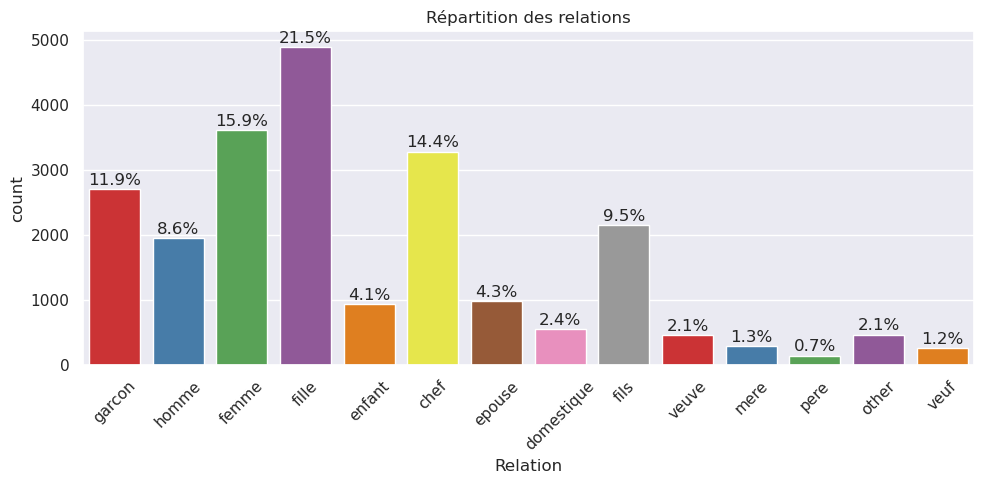

In [136]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x="Relation", data=df, palette='Set1', hue='Relation', legend=False)  
plt.title("Répartition des relations")

total = len(df["Relation"])
for p in ax.patches:
    percentage = f'{100*p.get_height()/total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Création X et y

In [137]:
#Formation de X et y
X=df[['Relation','Age']]
y=df['Target']
y=y.astype(bool).values

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

## Feature engineering 

In [138]:
relation_groups = ['fille','femme','chef','garcon','fils','homme','epouse','enfant','domestique','other','veuve','mere','veuf','pere']

age_moyen=[]
for relation in relation_groups:
    data=X_train[(X_train['Age']!=-1) & (X_train['Relation']==relation)]
    age_moyen.append(data['Age'].mean())

# Créer un dictionnaire pour stocker les âges moyens pour chaque groupe de relation
age_moyen_par_relation = dict(zip(relation_groups, age_moyen))

# Remplacer les âges manquants (-1) dans X_train
for relation, age_mean in age_moyen_par_relation.items():
    mask = (X_train['Age'] == -1) & (X_train['Relation'] == relation)
    X_train.loc[mask, 'Age'] = age_mean

# Remplacer les âges manquants (-1) dans X_test
for relation, age_mean in age_moyen_par_relation.items():
    mask = (X_test['Age'] == -1) & (X_test['Relation'] == relation)
    X_test.loc[mask, 'Age'] = age_mean

/tmp/ipykernel_441073/3114415021.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15.570945945945946' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[mask, 'Age'] = age_mean
/tmp/ipykernel_441073/3114415021.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15.570945945945946' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_test.loc[mask, 'Age'] = age_mean


## Decision Tree

In [139]:
numerical_cols = ['Age']
categorical_cols = ['Relation'] 

In [140]:
# Définir les transformations pour les colonnes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Normaliser les variables numériques
        ('cat_', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # Appliquer OneHotEncoder aux autres colonnes catégorielles
    ])

In [141]:
# Créer le pipeline avec le préprocesseur et le modèle RandomForest
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

In [142]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age']),
                                                 ('cat_',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Relation'])])),
                ('classifier', DecisionTreeClassifier())])

In [143]:
# Prédire sur l'ensemble d'entraînement
y_train_pred = pipeline.predict(X_train)

# Prédire sur l'ensemble de test
y_test_pred = pipeline.predict(X_test)

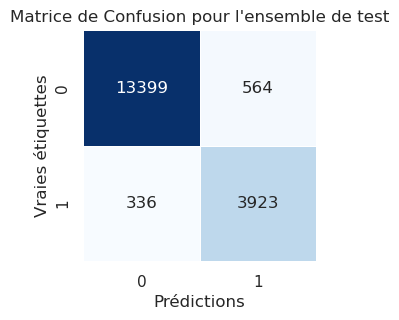

In [144]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_train, y_train_pred)

# Utiliser Seaborn pour l'affichage
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5, cbar=False)
plt.title('Matrice de Confusion pour l\'ensemble de test')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

In [145]:
# Calculer les métriques de performance
print("\nMétriques de performance :")
print(classification_report(y_train_pred, y_train))


Métriques de performance :
              precision    recall  f1-score   support

       False       0.96      0.98      0.97     13735
        True       0.92      0.87      0.90      4487

    accuracy                           0.95     18222
   macro avg       0.94      0.92      0.93     18222
weighted avg       0.95      0.95      0.95     18222



In [146]:
print('f1-score: ',f1_score(y_train_pred, y_train))
print('Precision: ',precision_score(y_train_pred, y_train))
print('Recall: ',recall_score(y_train_pred, y_train))

f1-score:  0.8970958152298193
Precision:  0.9211082413712139
Recall:  0.8743035435703143


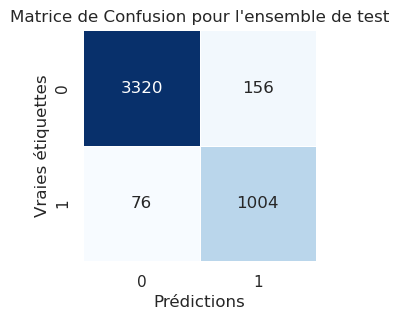

In [147]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)

# Utiliser Seaborn pour l'affichage
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5, cbar=False)
plt.title('Matrice de Confusion pour l\'ensemble de test')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

In [148]:
# Calculer les métriques de performance
print("\nMétriques de performance :")
print(classification_report(y_test_pred, y_test))


Métriques de performance :
              precision    recall  f1-score   support

       False       0.96      0.98      0.97      3396
        True       0.93      0.87      0.90      1160

    accuracy                           0.95      4556
   macro avg       0.94      0.92      0.93      4556
weighted avg       0.95      0.95      0.95      4556



In [149]:
print('f1-score: ',f1_score(y_test_pred, y_test))
print('Precision: ',precision_score(y_test_pred, y_test))
print('Recall: ',recall_score(y_test_pred, y_test))

f1-score:  0.8964285714285715
Precision:  0.9296296296296296
Recall:  0.8655172413793103


## Optimisation

In [150]:
# Définition du pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

In [151]:
# Définition des paramètres de la grille
param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [152]:
#Utilisation du gridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, scoring='f1', cv=5)

In [153]:
#Entraînement du modèle
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Age']),
                                                                        ('cat_',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Relation'])])),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [None, 10, 20, 30, 40, 50],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10]},
             scoring='f1')

In [154]:
# Meilleurs paramètres
best_model = grid_search.best_estimator_
print("Meilleurs paramètres trouvés : ", grid_search.best_params_)

Meilleurs paramètres trouvés :  {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10}


In [155]:
# Prédire sur l'ensemble d'entraînement
y_train_pred = best_model .predict(X_train)

# Prédire sur l'ensemble de test
y_test_pred = best_model .predict(X_test)

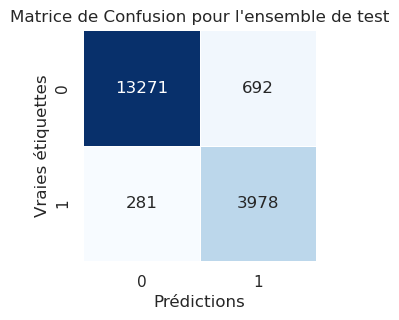

In [156]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_train, y_train_pred)

# Utiliser Seaborn pour l'affichage
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5, cbar=False)
plt.title('Matrice de Confusion pour l\'ensemble de test')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

In [157]:
# Calculer les métriques de performance
print("\nMétriques de performance :")
print(classification_report(y_train_pred, y_train))


Métriques de performance :
              precision    recall  f1-score   support

       False       0.95      0.98      0.96     13552
        True       0.93      0.85      0.89      4670

    accuracy                           0.95     18222
   macro avg       0.94      0.92      0.93     18222
weighted avg       0.95      0.95      0.95     18222



In [158]:
print('f1-score: ',f1_score(y_train_pred, y_train))
print('Precision: ',precision_score(y_train_pred, y_train))
print('Recall: ',recall_score(y_train_pred, y_train))

f1-score:  0.8910292305969314
Precision:  0.934022070908664
Recall:  0.8518201284796574


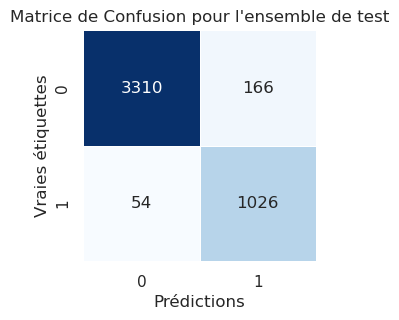

In [159]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)

# Utiliser Seaborn pour l'affichage
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5, cbar=False)
plt.title('Matrice de Confusion pour l\'ensemble de test')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

In [160]:
# Calculer les métriques de performance
print("\nMétriques de performance :")
print(classification_report(y_test_pred, y_test))


Métriques de performance :
              precision    recall  f1-score   support

       False       0.95      0.98      0.97      3364
        True       0.95      0.86      0.90      1192

    accuracy                           0.95      4556
   macro avg       0.95      0.92      0.94      4556
weighted avg       0.95      0.95      0.95      4556



In [161]:
print('f1-score: ',f1_score(y_test_pred, y_test))
print('Precision: ',precision_score(y_test_pred, y_test))
print('Recall: ',recall_score(y_test_pred, y_test))

f1-score:  0.903169014084507
Precision:  0.95
Recall:  0.860738255033557
